# Curso: Análise e engenharia de dados
# Atividade da disciplina Mineração de texto

# Exercício:

Analisar os tópicos nos tweets de Bolsonaro de agosto/2017 a agosto/2018.

```

https://raw.githubusercontent.com/ufrpe-ensino/curso-mineracao-textos/master/data/bolsonaro.csv

```

Quais os principais tópicos? Houve mudança ao longo do tempo?

In [ ]:
!pip install spacy
!spacy download pt

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
!pip install pyLDAvis

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import os
import spacy
import numpy as np
import pandas as pd
import nltk
import gensim
import re
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

**Inicialmente carrego os dados, obtenho algumas informações relevantes do mesmo e removo dados do tipo NaN**
***********************************************************************

In [ ]:
url = 'https://raw.githubusercontent.com/ufrpe-ensino/curso-mineracao-textos/master/data/bolsonaro.csv'
df = pd.read_csv(url, encoding='utf-8')
df.head()

,data,tweet
0,2017-08-01,venezuela esta sendo destruida pelo socialismo...
1,2017-08-01,quem pariu poa voz do pt paulo henrique amorim...
2,2017-08-01,toddynho pro moleque
3,2017-08-01,a apagou mas temos o
4,2017-08-01,falamos de agronegocio e n de grafeno e no mai...


In [ ]:
df.describe()

,data,tweet
count,1734,1734
unique,367,1717
top,2017-10-24,pesquisa eleicoes presidenciais
freq,19,3


In [ ]:
print(df.dtypes)

data     object
tweet    object
dtype: object


In [ ]:
df.nunique()

data      367
tweet    1717
dtype: int64

In [ ]:
null_counts = df.isna().sum()
print(null_counts)

data     0
tweet    0
dtype: int64


In [ ]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

**Nessa sessão defino uma função de limpeza e aplico nos dados**
***********************************************************************

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('portuguese'))
ponctuation = set(string.punctuation)
lemma = WordNetLemmatizer()

In [ ]:
def clean_text(doc):
    without_stop = " ".join([i for i in doc.lower().split() if i not in stop_words])
    without_punc = ''.join(i for i in without_stop if i not in ponctuation)
    normalized = " ".join(lemma.lemmatize(word) for word in without_punc.split())
    final_format = re.sub(r"http\S+", "", normalized).lower().replace(',','').replace('.','').replace(';','').replace('-','').replace(':','')
    return final_format

In [ ]:
df['tweet'] = [clean_text(tweet) for tweet in df['tweet']]

In [ ]:
df.head()

,data,tweet
0,2017-08-01,venezuela sendo destruida socialismo n podemos...
1,2017-08-01,pariu poa voz pt paulo henrique amorim faz cre...
2,2017-08-01,toddynho pro moleque
3,2017-08-01,apagou
4,2017-08-01,falamos agronegocio n grafeno n posso ajudar p...


**Abaixo aplico alguns métodos ensinados durantes as aulas para vetorização e tokenização dos tweets**
***********************************************************************

In [ ]:
vectorizer = CountVectorizer(analyzer='word',min_df=10,lowercase=True,
                             token_pattern='[a-zA-Z0-9]{4,}')

In [ ]:
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)

def preprocessamento(text, join=True):
    if join:
      text = ' '.join(tweet_tokenizer.tokenize(text))
    else:
      text = tweet_tokenizer.tokenize(text)
    return text

tokens_nltk = vectorizer.fit_transform(df['tweet'].apply(preprocessamento))
tokens_nltk

<1734x199 sparse matrix of type '<class 'numpy.int64'>'
	with 4495 stored elements in Compressed Sparse Row format>

**Aqui gero o modelo LDA com LatentDirichletAllocation e utilizo uma função vista durante as aulas para exibição dos tópicos**
***********************************************************************

In [ ]:
lda_model = LatentDirichletAllocation(n_components=10,
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1)
lda_output = lda_model.fit_transform(tokens_nltk)

In [ ]:
def mostrar_topicos(vectorizer=vectorizer, lda_model='', n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
topic_keywords = mostrar_topicos(vectorizer=vectorizer, lda_model=lda_model, n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Palavra '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Tópico '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Palavra 0,Palavra 1,Palavra 2,Palavra 3,Palavra 4,Palavra 5,Palavra 6,Palavra 7,Palavra 8,Palavra 9,Palavra 10,Palavra 11,Palavra 12,Palavra 13,Palavra 14
Tópico 0,voce,sistema,amor,poder,todo,quer,brasil,aqui,foro,governo,plano,favor,fazer,facebook,passagem
Tópico 1,sobre,contra,fala,economia,pessoas,menos,bolsonaro,jornal,politico,educacao,caso,campo,nada,caminho,armas
Tópico 2,brasil,parabens,sendo,apoio,ainda,crime,estado,mundo,outros,onde,enquanto,maior,deus,agradeco,pais
Tópico 3,bolsonaro,paulo,midia,verdade,imprensa,canal,populacao,folha,youtube,assista,deputado,tempo,link,nesta,controle
Tópico 4,obrigado,todos,serum,consideracao,corrupcao,nome,cada,grato,qualquer,sempre,pouco,junto,futuro,chegada,estar
Tópico 5,jair,abraco,grande,bolsonaro,presidente,noite,psdb,campanha,ditadura,pede,nunca,caso,alem,problema,contra
Tópico 6,esquerda,lula,pode,tudo,amigo,bolsonaro,estao,pais,apenas,assim,general,familia,vida,dizem,defesa
Tópico 7,hoje,povo,globo,liberdade,unidos,temas,combate,estados,melhor,filho,veja,cidadao,brasileiro,audiencia,muitos
Tópico 8,entrevista,porque,voto,dinheiro,militar,politica,impresso,muitos,policia,problema,alguem,desde,camara,querem,blica
Tópico 9,agora,sempre,vamos,pesquisa,direita,eleicoes,video,semana,toda,tambem,mudar,deus,imprensa,fakenews,alguns


**Abaixo utilizo pyLDAvis, ensinado durante as aulas, para visualizar o modelo LDA gerado a partir dos tweets do dataset carregado**
***********************************************************************

In [ ]:
import pyLDAvis.sklearn
import pyLDAvis
import matplotlib.pyplot as plt
#%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, 
                                 tokens_nltk, 
                                 vectorizer, 
                                 mds='tsne', 
                                 sort_topics=False)
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1   9.701115
1       0.648955  71.707100       2        1   9.916376
2      71.019684   9.971006       3        1  12.020535
3       3.785981  33.185135       4        1  11.752071
4     -42.666500  -9.222070       5        1  14.101507
5      -3.621689 -43.526516       6        1   9.118933
6      -3.632402  -4.171708       7        1   9.512017
7     -36.584400  35.804413       8        1   6.550048
8      44.391380  50.615383       9        1   7.098419
9      40.235809 -31.591665      10        1  10.228980, topic_info=             Term        Freq       Total Category  logprob  loglift
98           jair  109.000000  109.000000  Default  30.0000  30.0000
24         brasil  144.000000  144.000000  Default  29.0000  29.0000
174         sobre  100.000000  100.000000  Default  28.0000  28.0000
0          abraco   86.000000   86.000000  Default  27.0000  27.0000
126      obrigado  103.000000  103.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
163         redes    2.806577   12.162929  Topic10  -5.1212   0.8135
184         todos    9.732803  103.778938  Topic10  -3.8777  -0.0868
15          apoio    1.754108   23.874725  Topic10  -5.5913  -0.3309
40   compromissos    0.091880    9.340431  Topic10  -8.5405  -2.3417
0          abraco    0.170369   86.917090  Topic10  -7.9230  -3.9548

[390 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         6  0.989449   abraco
1        10  0.950641  adiante
2         1  0.456541  aeropoo
2         5  0.456541  aeropoo
3        10  0.981141    agora
...     ...       ...      ...
194      10  0.866296    video
195       5  0.880395  vitoria
196       1  0.981786     voce
197       9  0.985795     voto
198       4  0.947133  youtube

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

**Para verificar os principais tópicos em diferentes períodos, faço um agrupamento das informações por data, e em seguida gero 4 subconjuntos para agrupar por períodos entre 01-08-2017 e 16-08-2018**
***********************************************************************

In [ ]:
grouped_by_date = df.groupby('data', as_index = False).agg({'tweet': ' '.join})

In [ ]:
grouped_by_date.describe()

,data,tweet
count,367,367
unique,367,367
top,2018-06-16,grande grato bom domingo todos
freq,1,1


In [ ]:
grouped_by_date.head()

,data,tweet
0,2017-08-01,venezuela sendo destruida socialismo n podemos...
1,2017-08-02,ser grande nacao brasil precisa presidente hon...
2,2017-08-03,amigo apoiadores apoiados pt picou ditador bol...
3,2017-08-04,sao luis curu crescendo toda redes sociais vam...
4,2017-08-05,experimentem nivelar direita esquerda verao re...


In [ ]:
grouped_by_date.tail()

,data,tweet
362,2018-08-12,ido tempo nao roubava facebook nao esconde pol...
363,2018-08-13,entenda rapidamente significa socialismo grato...
364,2018-08-14,desinformar mentem fotos letras grandes corrig...
365,2018-08-15,nova pesquisa nacional eleicoes periodo sabati...
366,2018-08-16,bolsonaro nao nao empreiteiro livre acordoes c...


In [ ]:
size = int(len(grouped_by_date)*0.25)

In [ ]:
df_period_1 = grouped_by_date.iloc[:size]
df_period_2 = grouped_by_date.iloc[size:size*2]
df_period_3 = grouped_by_date.iloc[size*2:size*3]
df_period_4 = grouped_by_date.iloc[size*3:]

In [ ]:
df_period_1.head()

,data,tweet
0,2017-08-01,venezuela sendo destruida socialismo n podemos...
1,2017-08-02,ser grande nacao brasil precisa presidente hon...
2,2017-08-03,amigo apoiadores apoiados pt picou ditador bol...
3,2017-08-04,sao luis curu crescendo toda redes sociais vam...
4,2017-08-05,experimentem nivelar direita esquerda verao re...


In [ ]:
df_period_4.tail()

,data,tweet
362,2018-08-12,ido tempo nao roubava facebook nao esconde pol...
363,2018-08-13,entenda rapidamente significa socialismo grato...
364,2018-08-14,desinformar mentem fotos letras grandes corrig...
365,2018-08-15,nova pesquisa nacional eleicoes periodo sabati...
366,2018-08-16,bolsonaro nao nao empreiteiro livre acordoes c...


**Para verificar os principais tópicos em cada um dos quatro períodos, gero imagens com WordCloud() e em seguida exibo-as**
***********************************************************************

In [ ]:
def show_main_topics(text):
  set_text = " ".join(review for review in df_period_1.tweet)
  wordcloud = WordCloud().generate(set_text)
  plt.figure(figsize = (40,4))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

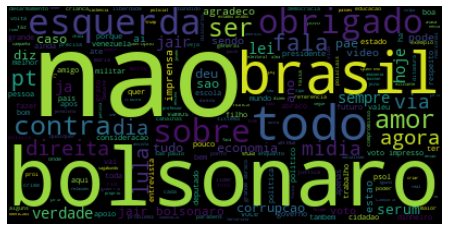

In [ ]:
show_main_topics(df_period_1.tweet)

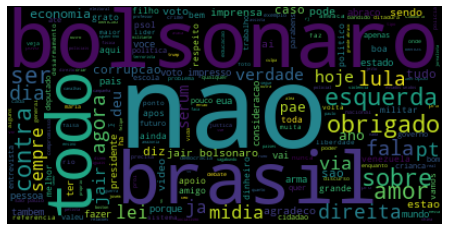

In [ ]:
show_main_topics(df_period_2.tweet)

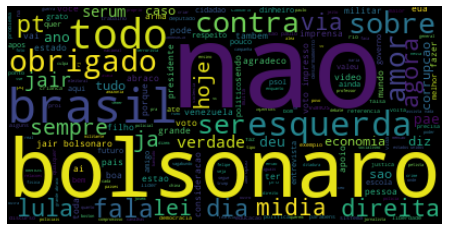

In [ ]:
show_main_topics(df_period_3.tweet)

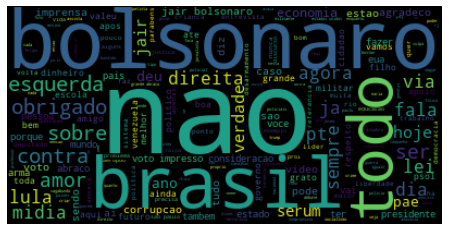

In [ ]:
show_main_topics(df_period_4.tweet)

***********************************************************************
**Conforme as imagens com tópicos por período, é possível concluir que os principais tópicos se mantiveram semelhantes.**
***********************************************************************